In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


data_path = "archive/cell_images"  

# Infected ve Uninfected klasörlerini kontrol edelim
infected_dir = os.path.join(data_path, 'Parasitized')
uninfected_dir = os.path.join(data_path, 'Uninfected')

print("Infected klasöründeki toplam resim sayısı:", len(os.listdir(infected_dir)))
print("Uninfected klasöründeki toplam resim sayısı:", len(os.listdir(uninfected_dir)))



Infected klasöründeki toplam resim sayısı: 13790
Uninfected klasöründeki toplam resim sayısı: 12898


In [2]:
# DataFrame oluşturmak için resim yollarını ve etiketleri toplayalım

image_paths = []
labels = []

# Infected klasörü için
for filename in os.listdir(infected_dir):
    image_paths.append(os.path.join(infected_dir, filename))
    labels.append('Infected')

# Uninfected klasörü için
for filename in os.listdir(uninfected_dir):
    image_paths.append(os.path.join(uninfected_dir, filename))
    labels.append('Uninfected')

# DataFrame oluştur
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Karıştıralım (shuffle)
df = df.sample(frac=1).reset_index(drop=True)

# İlk 5 satırı görelim
df.head()


,image_path,label
0,archive/cell_images\Uninfected\C120P81ThinF_IM...,Uninfected
1,archive/cell_images\Uninfected\C231ThinF_IMG_2...,Uninfected
2,archive/cell_images\Parasitized\C45P6ThinF_IMG...,Infected
3,archive/cell_images\Parasitized\C173P134NThinF...,Infected
4,archive/cell_images\Uninfected\C65P26N_ThinF_I...,Uninfected


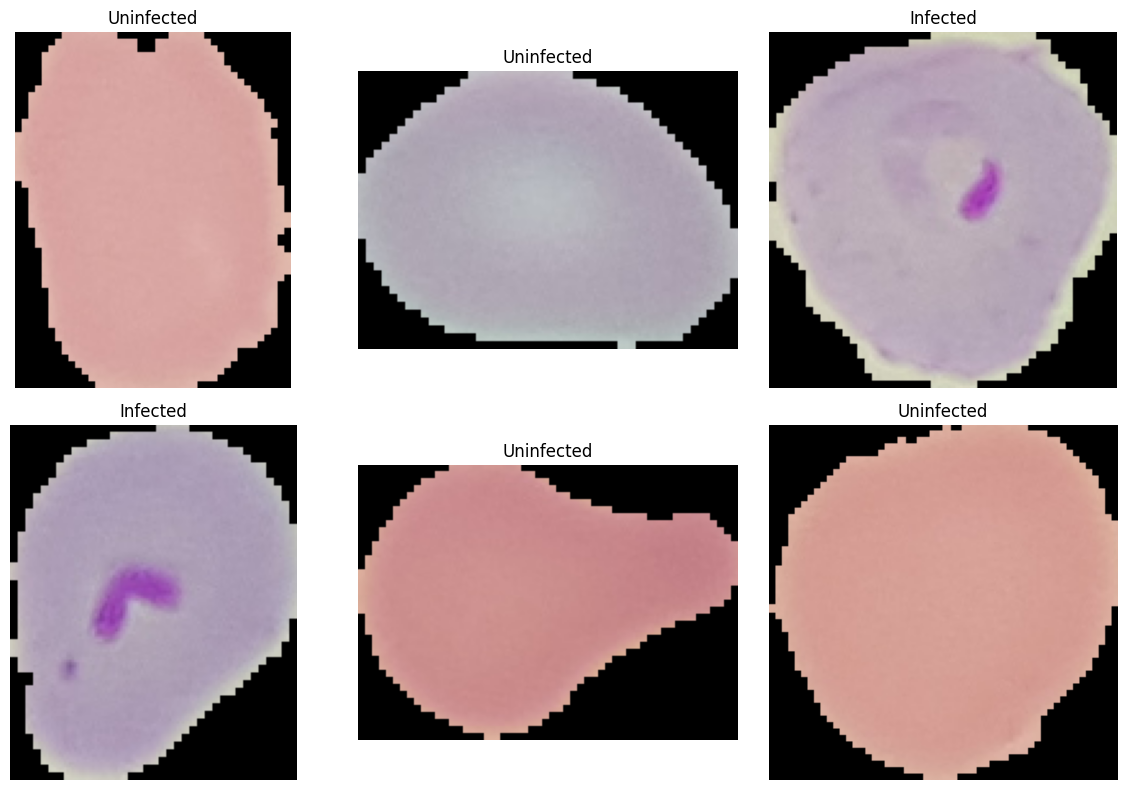

In [3]:
# Görsellerin nasıl göründüğünü görelim
import matplotlib.pyplot as plt
import cv2

# Rastgele 6 resim gösterelim
plt.figure(figsize=(12, 8))

for i in range(6):
    # i. satırdaki resim
    img_path = df.iloc[i]['image_path']
    label = df.iloc[i]['label']
    
    # OpenCV ile oku (cv2.IMREAD_COLOR = renkli)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV BGR olarak okur, RGB'ye çevirdik
    
    # Plot
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
# Etiketleri sayısal hale getirelim (binary classification için)
df['label_encoded'] = df['label'].apply(lambda x: 1 if x == 'Infected' else 0)

# Önce train ve temp (validation + test) olarak ayırıyoruz
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label_encoded'], random_state=42)

# Temp'i validation ve test olarak ikiye böl
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_encoded'], random_state=42)

# Kaç tane veri olduğunu görelim
print("Train set:", len(train_df))
print("Validation set:", len(val_df))
print("Test set:", len(test_df))


Train set: 18681
Validation set: 4003
Test set: 4004


In [5]:
IMAGE_SIZE = 170
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


Found 18680 validated image filenames belonging to 2 classes.
Found 4003 validated image filenames belonging to 2 classes.


C:\Users\Fahr\anaconda3\envs\tfenv\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 4003 validated image filenames belonging to 2 classes.


C:\Users\Fahr\anaconda3\envs\tfenv\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [6]:
# CNN 

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 168, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 128)      

In [ ]:

EPOCHS = 10

# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


Epoch 1/10


212/584 [=========>....................] - ETA: 2:02 - loss: 0.6863 - accuracy: 0.5494 

In [ ]:
# Accuracy / Val Accuracy Grafiği
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediction
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Gerçek etiketler
true_classes = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())

# Görselleştirme
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Prediction (test set)
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Gerçek etiketler
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# RANDOM 6 tane görsel seçelim
import random
random_indices = random.sample(range(len(test_df)), 6)

# Görsel gösterme
plt.figure(figsize=(12, 8))

for i, idx in enumerate(random_indices):
    img_path = test_df.iloc[idx]['image_path']
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    
    pred_label = class_labels[predicted_classes[idx]]
    true_label = class_labels[true_classes[idx]]
    
    plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

model.save("malaria_cnn_model.h5")
print("Model kaydedildi: malaria_cnn_model.h5")
